In [743]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock, seuclidean

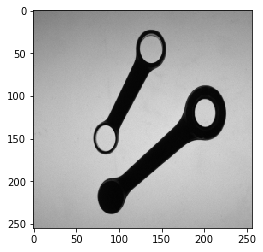

In [744]:
img = cv2.imread('images/TESI21.BMP')
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray');

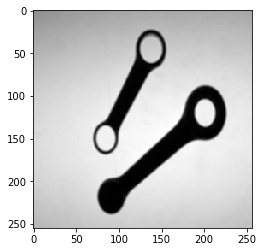

In [745]:
# Blur the image to threshold the image more easily

smoothedImg = cv2.blur(imgGray, (3, 3))
# smoothedImg = cv2.medianBlur(img, 5)
# smoothedImg = cv2.GaussianBlur(img, (7, 7), 0)
plt.imshow(smoothedImg, cmap='gray');

Smoothing is done to prevent error in binarization (i.e.: TESI47.BMP)

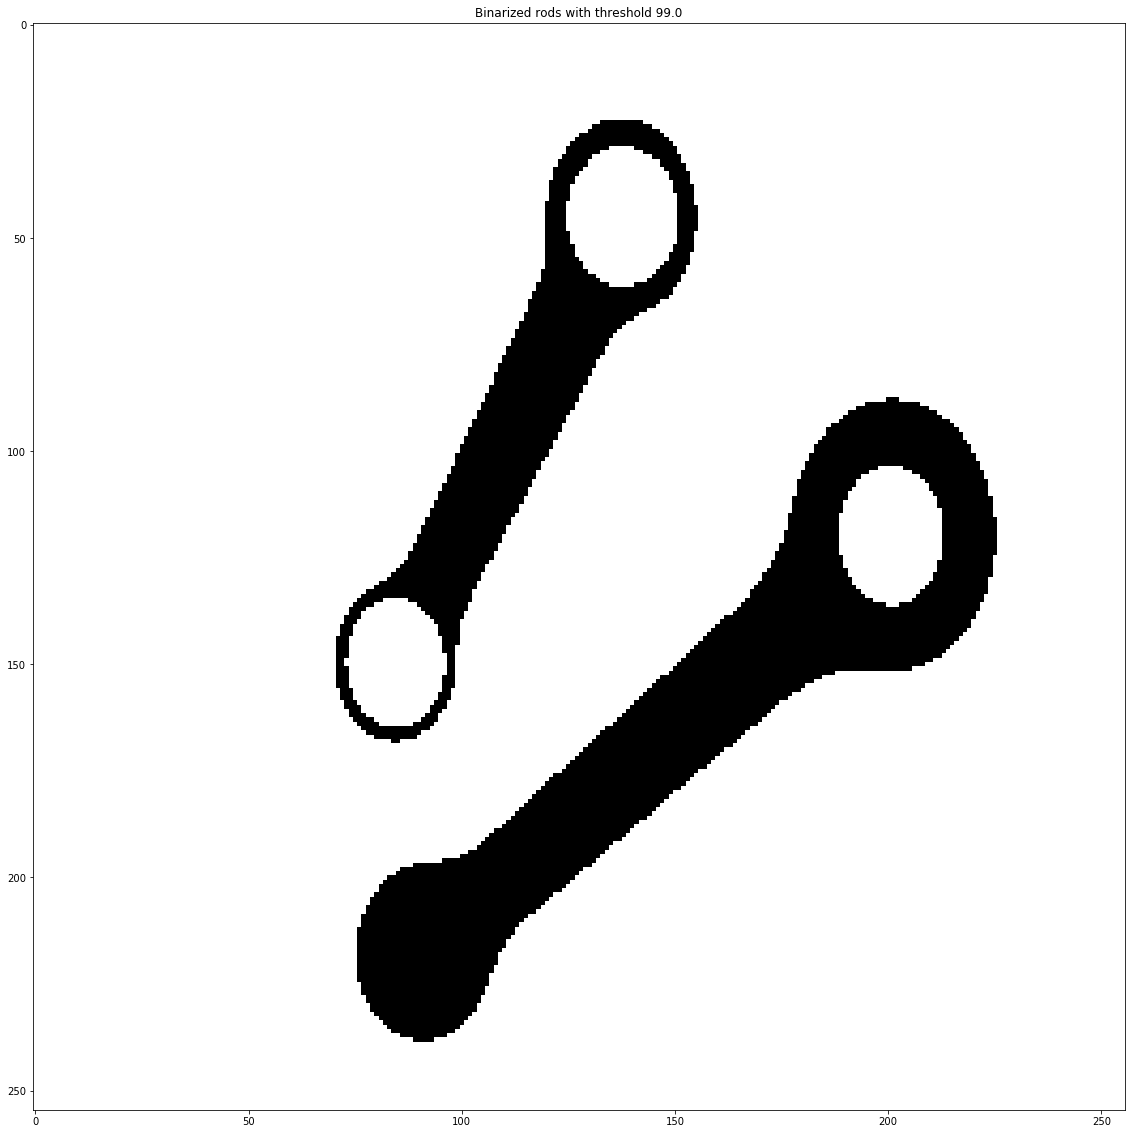

In [746]:
# Smooth the image with Otsu's algorithm
threshold, threshImg = cv2.threshold(smoothedImg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(20, 20))
plt.title('Binarized rods with threshold ' + str(threshold))
plt.imshow(threshImg, cmap='gray');

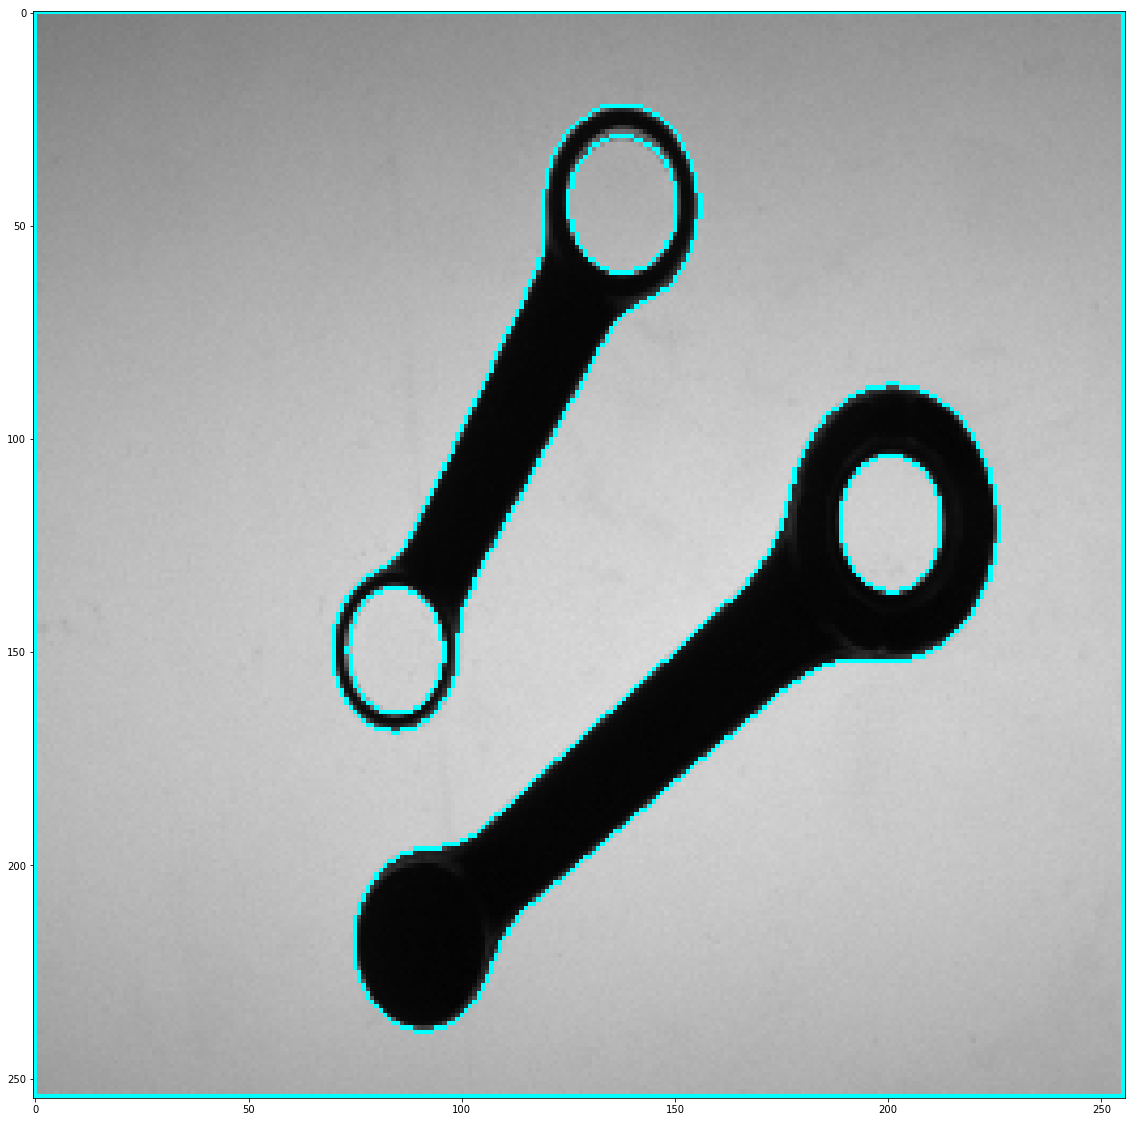

In [747]:
_, contours, hierarchy = cv2.findContours(threshImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contoursImg = img.copy()

cv2.drawContours(contoursImg, contours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(contoursImg);

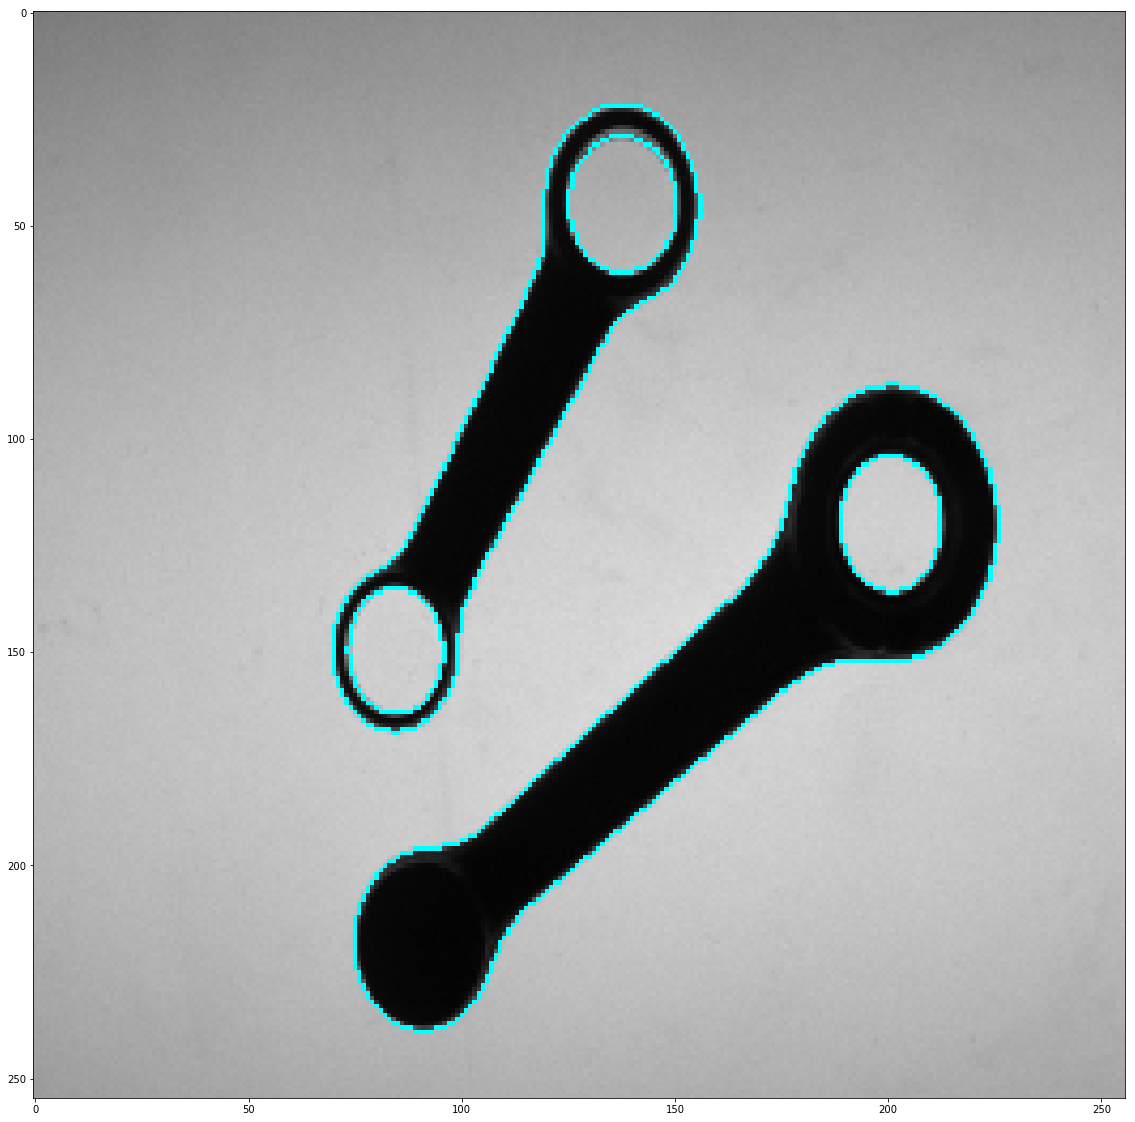

In [748]:
imgBorderIndex = np.argmax([cv2.contourArea(cnt) for cnt in contours])
allContours = np.delete(contours, imgBorderIndex)
allHierarchy = np.delete(hierarchy.reshape((-1, 4)), imgBorderIndex, axis=0)

contoursImg = img.copy()

cv2.drawContours(contoursImg, allContours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(contoursImg);

In [749]:
n_rods = np.sum(allHierarchy[:,3] == 0)
n_rods

2

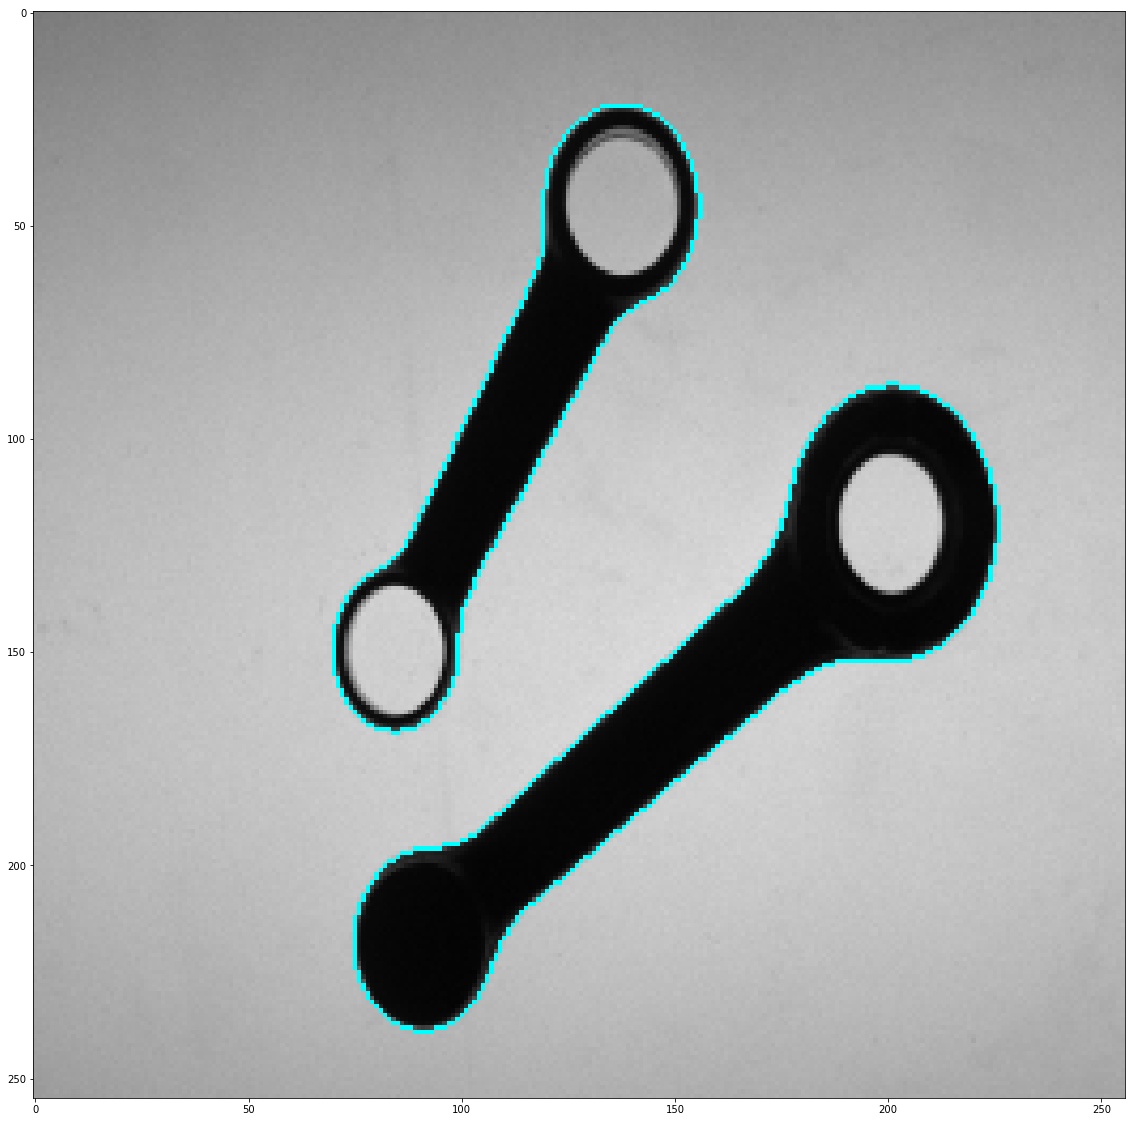

In [750]:
# Filter the outer contours
rodsContours = allContours[allHierarchy[:, 3] == 0]

rodsContoursImg = img.copy()

cv2.drawContours(rodsContoursImg, rodsContours, -1, (0, 255, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(rodsContoursImg);

In [751]:
#print(allHierarchy[:, 3] == 0)
#print(allHierarchy)
indexes = np.where(allHierarchy[:, 3] == 0)[0]
#print(indexes) # Must add 1
#for i in indexes:
#    print(allHierarchy[:, 3] == i + 1)
#[euclidean((50, 50), c) for c in contours[1].reshape(-1, 2)]

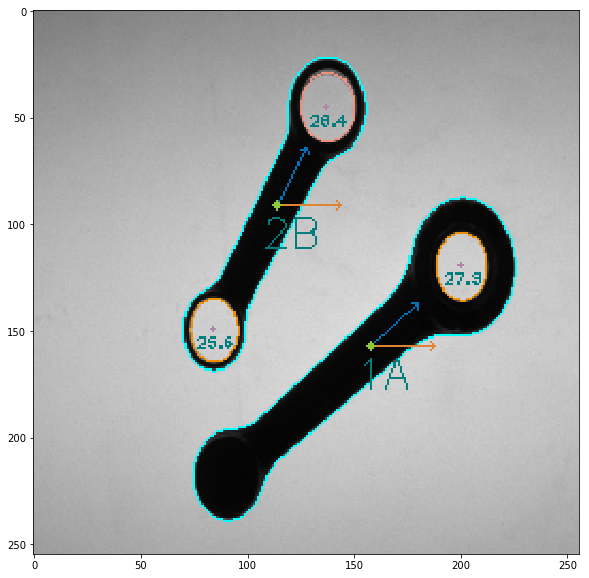

In [777]:
posImg = rodsContoursImg.copy()
rodIndex = 1

for i, cnt in enumerate(rodsContours):
    holesCount = np.sum(allHierarchy[:, 3] == indexes[i] + 1)
    
    # Compute center of mass
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Compute area and perimeter
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    compactness = (perimeter ** 2) / area
    #print(str(rodIndex) + ':\t', compactness)
    
    if holesCount <= 0 or holesCount >= 3 or compactness < 20:
        continue
    else:
        # Draw bounding box
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        # cv2.drawContours(posImg, [box], 0, (242, 183, 159), 1)
        
        # Compute width at the barycenter (MIGLIORABILE)
        cntPoints = cnt.reshape(-1, 2)
        minPoint1 = cntPoints[np.argmin([euclidean(c, (cx, cy)) for c in cntPoints])]
        minPoint2 = 2 * np.array([cx, cy]) - minPoint1
        # cv2.line(posImg, tuple(minPoint1), tuple(minPoint2), (102, 157, 49))
        
        # Compute angle, lenght and width
        (x, y), (length, width), angle = cv2.fitEllipse(cnt)
        angle = int(180 + ((angle % 180) - 90) * (-1)) % 180
        arrowLength = 30
        radians = - angle * np.pi / 180

        #print(length, width)
        
        x2 = int(round(np.cos(radians) * arrowLength + cx))
        y2 = int(round(np.sin(radians) * arrowLength + cy))

        cv2.arrowedLine(posImg, (cx, cy), (cx + arrowLength, cy), (225, 131, 53))
        cv2.arrowedLine(posImg, (cx, cy), (x2, y2), (0, 114, 187))

        cv2.circle(posImg, (cx, cy), 2, (143, 201, 58), -1)
        
        # Position and diameter of hole
        holes = allContours[allHierarchy[:, 3] == indexes[i] + 1]
        for n, hole in enumerate(holes):
            cv2.drawContours(posImg, hole.reshape(1, -1, 2), -1, (241, 143, n*125), 1)
            
            Mhole = cv2.moments(hole)
            cxHole = int(Mhole['m10']/Mhole['m00'])
            cyHole = int(Mhole['m01']/Mhole['m00'])
            
            cv2.circle(posImg, (cxHole, cyHole), 1, (177, 133, 167), -1)
            
            holeArea = cv2.contourArea(hole)
            equi_diameter = round(np.sqrt(4 * holeArea / np.pi), 1)
            cv2.putText(posImg, str(equi_diameter), (cxHole - 8, cyHole + 9), cv2.FONT_HERSHEY_PLAIN, 0.5, (0, 125, 125), 1)
        
        # Classify rod
        if holesCount == 1:
            cv2.putText(posImg, str(rodIndex) + 'A', (cx - 7, cy + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.66, (0, 125, 125), 1)
        elif holesCount == 2:
            cv2.putText(posImg, str(rodIndex) + 'B', (cx - 7, cy + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.66, (0, 125, 125), 1)

        # cv2.putText(posImg, str(angle), (cx + 5, cy + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.66, (0, 225, 0), 1)

        rodIndex += 1    
    
    
plt.figure(figsize=(10, 10))
plt.imshow(posImg);